In [18]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import torch
import yaml
import os
from utilities.script_func import occupancy_pre
import numpy as np
from xai_ts_utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data

In [20]:
experiment_id = 0 # 0, 1, 2 , 3, 4
dataset_id = 1 # 0, 1 # BOTH used in paper

In [21]:
import pickle

data_path = f'./experiments/unisimul_study/exp_log{experiment_id}/dataset{dataset_id}.pkl'

with open(data_path, 'rb') as file:
    timeseries, labels = pickle.load(file)

n_classes = len(np.unique(labels))
timeseries.shape, labels.shape

((900, 1000), (900,))

In [22]:
# for target_class in range(n_classes):
#     subset = timeseries[labels == target_class]
#     for i in range(len(subset)):
#         plt.plot(subset[i], color='grey', alpha=0.01)
#     plt.title(f'Class {target_class}')
#     plt.show()

In [23]:
import Models.models as Models
import Models.model_func as Model_Func
from Models.SimulationStudyBaseline_Model import UnivariateSimulationStudyBaseline_Model

baseline_model= UnivariateSimulationStudyBaseline_Model(device=device, input_dim=timeseries.shape[1], classes=3).to(device)
model= Models.Univariate_IEGradient(device=device, input_dim=timeseries.shape[1],
                                      model=baseline_model).to(device)

state_dict_path = f'experiments/unisimul_study/exp_log{experiment_id}/Grad/state_dict/unisimul_study{dataset_id}-Grad-state_dict-50.pt'

state_dict = torch.load(state_dict_path)
model.load_state_dict(state_dict, strict=True)
model.eval()

Univariate_IEGradient(
  (model): UnivariateSimulationStudyBaseline_Model(
    (layer_0): Linear(in_features=1000, out_features=3, bias=True)
  )
)

In [24]:
subset_size = -1

all_samples = torch.tensor(timeseries, dtype = torch.float, device=device, requires_grad=True)
display(all_samples.shape)

predicted_classes = model(all_samples).argmax(axis=1).cpu().detach().numpy()
print(predicted_classes.shape)
predicted_classes == labels

torch.Size([900, 1000])

(900,)


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [25]:
torch.backends.cudnn.enabled=False
# explainer = InputXGradient(model)
explainer = DeepLift(model)
# explainer = IntegratedGradients(model)

target_classes = [0,1,2]
for target_class in target_classes:
    class_subset = all_samples[labels == target_class]

    explanations = explainer.attribute(class_subset, target=target_class).cpu().detach().numpy()
    mean_explanation = explanations.mean(axis=0).reshape(1,-1)
    max_explanation = explanations.max(axis=0).reshape(1,-1)
    mean_ts = class_subset.mean(axis=0).cpu().detach().numpy().reshape(1,-1)

    # plot_timeseries_with_explanation(mean_ts, mean_explanation, title=f'Mean explanation | Experiment id: {experiment_id} | dataset id: {dataset_id} | Class: {target_class}')
    # plt.show()

    # plot_timeseries_with_explanation(mean_ts, max_explanation, title=f'Max explanation | Experiment id: {experiment_id} | dataset id: {dataset_id} | Class: {target_class}')
    # plt.show()
    mean_explanation

    print()
    print()
    print()

## Alternate visualization over all models

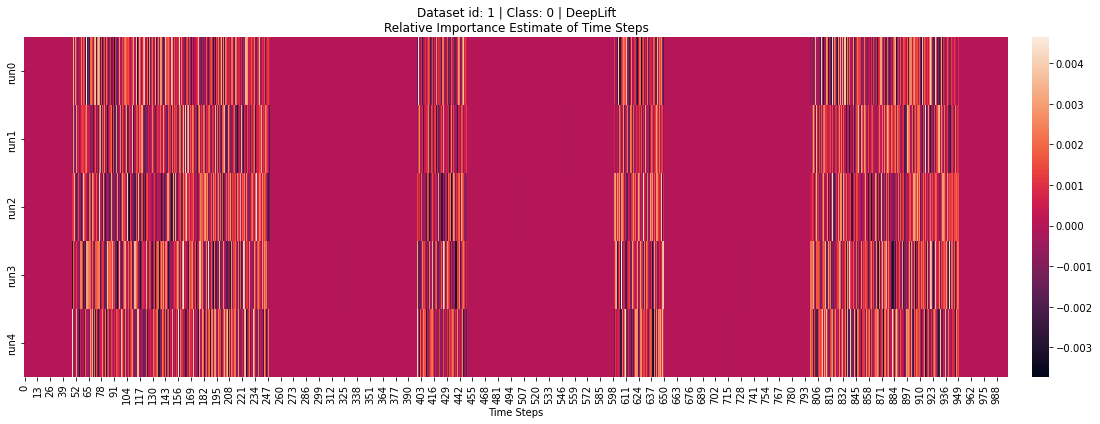

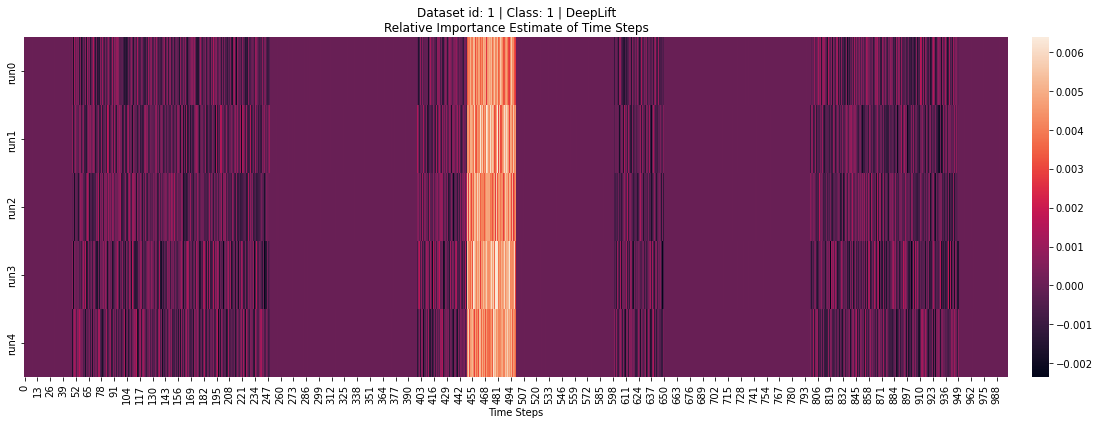

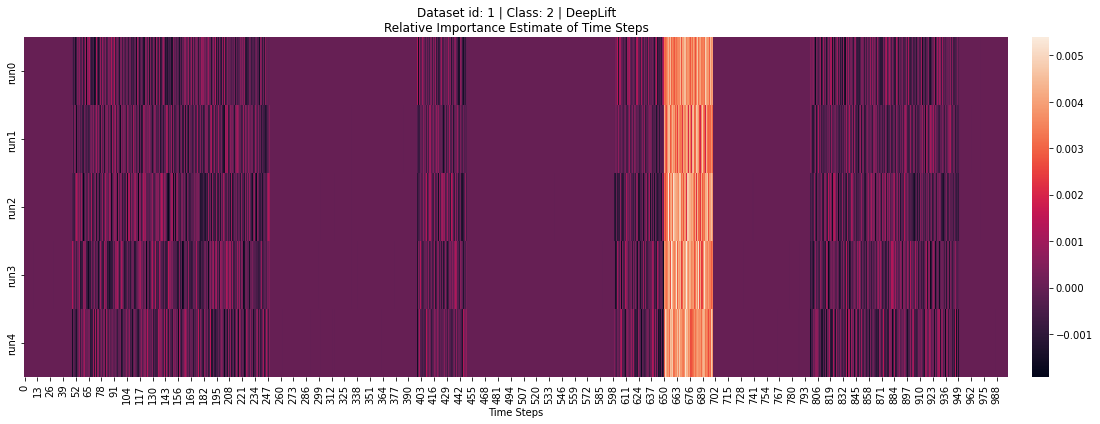

In [26]:
import Models.models as Models
import Models.model_func as Model_Func
from Models.SimulationStudyBaseline_Model import UnivariateSimulationStudyBaseline_Model

n_runs = 5

xai_plots_savepath = 'xai_plots'

target_classes = [0,1,2]
for target_class in target_classes:
    class_subset = all_samples[labels == target_class]

    run_mean_explanations = []

    for run_id in range(n_runs):
        # load model
        baseline_model= UnivariateSimulationStudyBaseline_Model(device=device, input_dim=timeseries.shape[1], classes=3).to(device)
        model= Models.Univariate_IEGradient(device=device, input_dim=timeseries.shape[1],model=baseline_model).to(device)

        state_dict_path = f'experiments/unisimul_study/exp_log{run_id}/Grad/state_dict/unisimul_study{dataset_id}-Grad-state_dict-50.pt'

        state_dict = torch.load(state_dict_path)
        model.load_state_dict(state_dict, strict=True)
        model.eval()

        # initialize explainer and generate mean explanation
        torch.backends.cudnn.enabled=False
        explainer = DeepLift(model)
        explainer_name = explainer.__class__.__name__

        explanations = explainer.attribute(class_subset, target=target_class).cpu().detach().numpy()
        mean_explanation = explanations.mean(axis=0).reshape(1,-1)
        max_explanation = explanations.max(axis=0).reshape(1,-1)
        mean_ts = class_subset.mean(axis=0).cpu().detach().numpy().reshape(1,-1)

        # plot_timeseries_with_explanation(mean_ts, mean_explanation, title=f'Mean explanation | Experiment id: {experiment_id} | dataset id: {dataset_id} | Class: {target_class}')
        # plt.show()

        # plot_timeseries_with_explanation(mean_ts, max_explanation, title=f'Max explanation | Experiment id: {experiment_id} | dataset id: {dataset_id} | Class: {target_class}')
        # plt.show()
        run_mean_explanations.append(mean_explanation.reshape(-1))
    run_mean_explanations = np.array(run_mean_explanations)

    x_labels=  [f"channel{i}" for i in range(class_subset.shape[1])]
    y_labels= [f"run{i}" for i in range(n_runs)]
    plt.figure(figsize=(17,6))
    sns.heatmap(run_mean_explanations, xticklabels="auto", yticklabels=y_labels,annot=False, cbar_kws={"pad":0.02})
    plt.xlabel("Time Steps")
    plt.title(f"Dataset id: {dataset_id} | Class: {target_class} | {explainer_name}\nRelative Importance Estimate of Time Steps")
    plt.tight_layout()

    # save plots
    plot_save_path = os.path.join(xai_plots_savepath,'unisimul_study', f'dataset{dataset_id}') # , f'class_{target_class}_{explainer_name}'
    os.makedirs(plot_save_path, exist_ok=True)
    plt.savefig(os.path.join(plot_save_path, f'class_{target_class}_{explainer_name}.png'), facecolor='white')
    
    plt.show()


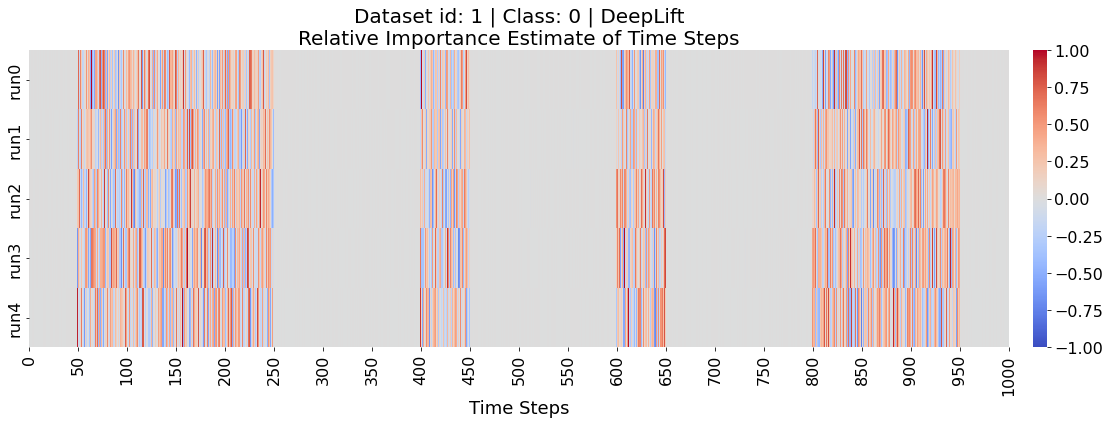

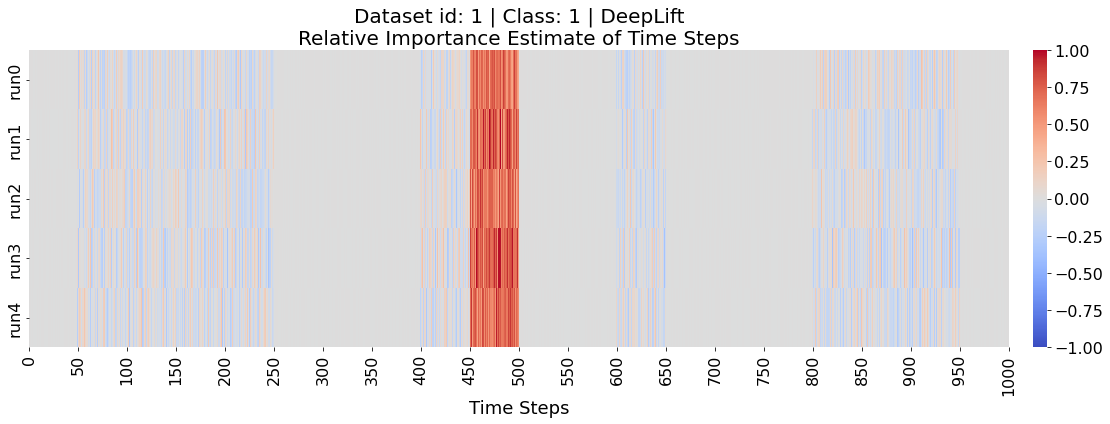

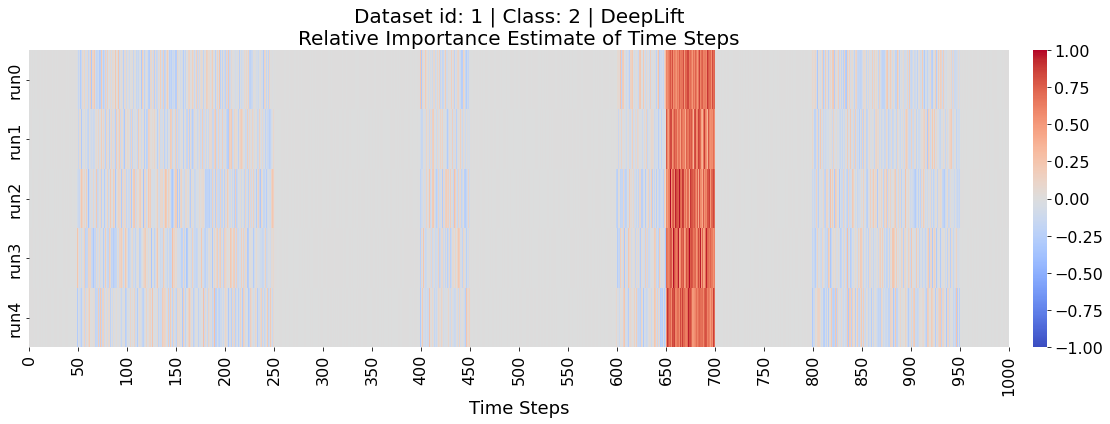

In [27]:
import Models.models as Models
import Models.model_func as Model_Func
from Models.SimulationStudyBaseline_Model import UnivariateSimulationStudyBaseline_Model

n_runs = 5

xai_plots_savepath = 'xai_plots_coolwarm'

target_classes = [0,1,2]
for target_class in target_classes:
    class_subset = all_samples[labels == target_class]

    run_mean_explanations = []

    for run_id in range(n_runs):
        # load model
        baseline_model= UnivariateSimulationStudyBaseline_Model(device=device, input_dim=timeseries.shape[1], classes=3).to(device)
        model= Models.Univariate_IEGradient(device=device, input_dim=timeseries.shape[1],model=baseline_model).to(device)

        state_dict_path = f'experiments/unisimul_study/exp_log{run_id}/Grad/state_dict/unisimul_study{dataset_id}-Grad-state_dict-50.pt'

        state_dict = torch.load(state_dict_path)
        model.load_state_dict(state_dict, strict=True)
        model.eval()

        # initialize explainer and generate mean explanation
        torch.backends.cudnn.enabled=False
        explainer = DeepLift(model)
        explainer_name = explainer.__class__.__name__

        explanations = explainer.attribute(class_subset, target=target_class).cpu().detach().numpy()
        mean_explanation = explanations.mean(axis=0).reshape(1,-1)
        max_explanation = explanations.max(axis=0).reshape(1,-1)
        mean_ts = class_subset.mean(axis=0).cpu().detach().numpy().reshape(1,-1)

        # plot_timeseries_with_explanation(mean_ts, mean_explanation, title=f'Mean explanation | Experiment id: {experiment_id} | dataset id: {dataset_id} | Class: {target_class}')
        # plt.show()

        # plot_timeseries_with_explanation(mean_ts, max_explanation, title=f'Max explanation | Experiment id: {experiment_id} | dataset id: {dataset_id} | Class: {target_class}')
        # plt.show()
        run_mean_explanations.append(mean_explanation.reshape(-1))
    run_mean_explanations = np.array(run_mean_explanations)

    x_labels=  [f"channel{i}" for i in range(class_subset.shape[1])]
    y_labels= [f"run{i}" for i in range(n_runs)]
    plt.figure(figsize=(17,6))
    extent = max(abs(run_mean_explanations.min()),abs(run_mean_explanations.max()))
    run_mean_explanations /= extent
    heatmap = sns.heatmap(run_mean_explanations, xticklabels="auto", yticklabels=y_labels,annot=False, cbar_kws={"pad":0.02}, cmap='coolwarm', vmin=-1, vmax=1 )
    plt.xlabel("Time Steps", fontsize=18)
    plt.xticks(np.arange(0, run_mean_explanations.shape[-1]+1, 50),np.arange(0, run_mean_explanations.shape[-1]+1, 50), fontsize=16)
    plt.setp(heatmap.get_yticklabels(), fontsize=16)
    plt.title(f"Dataset id: {dataset_id} | Class: {target_class} | {explainer_name}\nRelative Importance Estimate of Time Steps", fontsize=20)
    colorbar = heatmap.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=16)
    
    plt.tight_layout()

    # save plots
    plot_save_path = os.path.join(xai_plots_savepath,'unisimul_study', f'dataset{dataset_id}') # , f'class_{target_class}_{explainer_name}'
    os.makedirs(plot_save_path, exist_ok=True)
    plt.savefig(os.path.join(plot_save_path, f'class_{target_class}_{explainer_name}.png'), facecolor='white')
    
    plt.show()
